# Implementation of Pix2Pix GAN

In [1]:
#Installing tensorflow 2.15.0 to avoid Memory Leak present in current versions (2.17.0)
!pip install tensorflow==2.15.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 38.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 37.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 75.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 26.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 7.4 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.0
    Uninstalling ml-dtypes-0.4.0:
      Successfully uninstalled ml-dtypes-0.4.0
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
  Attempting uninstall: tensorboard
    Found existing installation

In [2]:
#importing dataset from github
!git clone https://github.com/IgorRahzel/mapsDataset.git

Cloning into 'mapsDataset'...
remote: Enumerating objects: 2199, done.
remote: Total 2199 (delta 0), reused 0 (delta 0), pack-reused 2199
Receiving objects: 100% (2199/2199), 238.88 MiB | 16.07 MiB/s, done.
Updating files: 100% (2194/2194), done.


In [3]:
#dataset path on google colab
DATASET_PATH = 'mapsDataset/maps/train'

# Implementing Data Loader

In [4]:
import tensorflow as tf
from os import listdir
from os.path import join
from keras.utils import load_img
import numpy as np
import matplotlib.pyplot as plt

def LoadData(path,size = (256,512)):
  src_list = []
  tar_list = []
  for filename in listdir(path):
    #getting path of image
    path_file = join(path,filename)
    #loading image
    img = load_img(path_file,target_size=size)
    #converting image to array
    img = np.array(img)
    #splitting image pairs
    src_img = img[:,:256]
    tar_img = img[:,256:]
    #appending images to list
    src_list.append(src_img)
    tar_list.append(tar_img)
  return [np.asarray(src_list),np.asarray(tar_list)]

src_images,tar_images = LoadData(DATASET_PATH)

# Visualizing Images

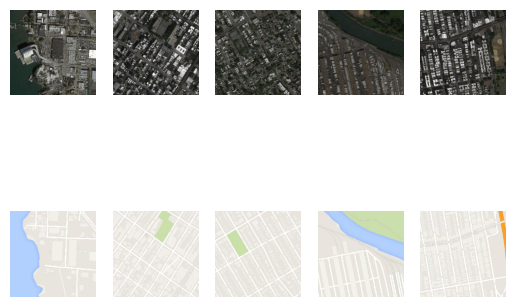

In [5]:

# function to plot source and target images
def plot_images(src_images, tar_images, n_samples=5):
    for i in range(n_samples):
        # define subplot
        plt.subplot(2, n_samples, 1 + i)
        # plot source image
        plt.axis('off')
        plt.imshow(src_images[i].astype('uint8'))
    for i in range(n_samples):
        # define subplot
        plt.subplot(2, n_samples, 1 + n_samples + i)
        # plot target image
        plt.axis('off')
        plt.imshow(tar_images[i].astype('uint8'))
    plt.show()

# plot images
plot_images(src_images, tar_images)

# Implementing the Discriminator
As outlined in the original Pix2Pix GAN paper (https://arxiv.org/pdf/1611.07004), the discriminator follows an architecture denoted as C64-C128-C256-C512, where each Ck represents a Convolution-BatchNorm-ReLU layer with k filters.

After the last layer, a convolution is applied to map to a 1-dimensional output, followed by a Sigmoid function.
As an exception to the above notation, BatchNorm is not
applied to the first C64 layer. All ReLUs are leaky, with
slope 0.2.

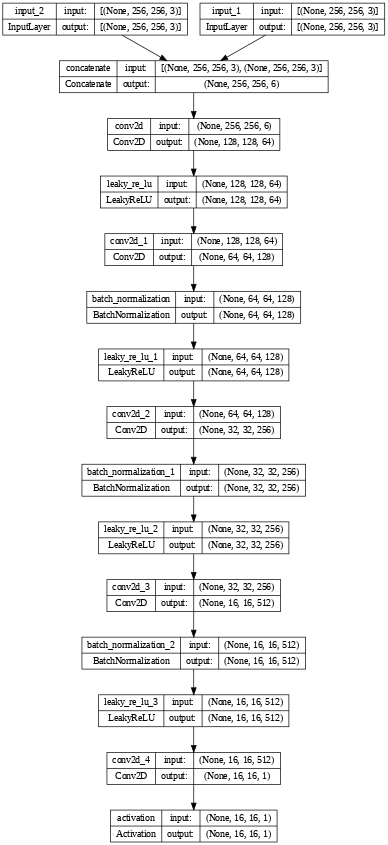

In [6]:
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.models import Model
from keras.optimizers import Adam
from keras.utils import plot_model

def discriminator_model(image_shape):
  #defining the shape of the input images
  tar_img = Input(shape=image_shape)
  src_img = Input(shape=image_shape)
  #concatenating the images
  merged = Concatenate()([src_img,tar_img])

  #C64
  #Convolution->ReLU
  d = Conv2D(64,(4,4),strides=(2,2),padding='same')(merged)
  d = LeakyReLU(alpha=0.2)(d)

  #C128
  #Convolution->BatchNorm->ReLU
  d = Conv2D(128,(4,4),strides=(2,2),padding='same')(d)
  d = BatchNormalization()(d)
  d = LeakyReLU(alpha=0.2)(d)

  #C256
  #Convolution->BatchNorm->ReLU
  d = Conv2D(256,(4,4),strides=(2,2),padding='same')(d)
  d = BatchNormalization()(d)
  d = LeakyReLU(alpha=0.2)(d)

  #C512
  #Convolution->BatchNorm->ReLU
  d = Conv2D(512,(4,4),strides=(2,2),padding='same')(d)
  d = BatchNormalization()(d)
  d = LeakyReLU(alpha=0.2)(d)

  #patch output
  #Convolution->Sigmoid
  d = Conv2D(1,(4,4),padding='same')(d)
  patch_out = Activation('sigmoid')(d)

  model = Model([tar_img,src_img],patch_out)
  opt = Adam(learning_rate=0.0002,beta_1=0.5)
  model.compile(loss='binary_crossentropy',optimizer=opt,loss_weights=0.5)
  return model

discriminator = discriminator_model((256,256,3))
plot_model(discriminator,show_shapes=True,show_layer_names=True,dpi=50)

# Implementing the Generator
The generator architecture described in the Pix2Pix GAN paper can be divided into two main parts: the encoder and the decoder. The encoder consists of the following layers: C64-C128-C256-C512-C512-C512-C512-C512. The decoder is composed of: CD512-CD512-CD512-C512-C256-C128-C64.

In the encoder, each Ck layer follows the same structure as the discriminator, with each layer representing a Convolution-BatchNorm-ReLU operation. In contrast, the CDk layers in the decoder denote a Convolution-BatchNorm-Dropout-ReLU operation, with a 50% dropout rate. All convolutions use 4x4 spatial filters applied with a stride of 2.

As noted in the paper, an exception to the standard notation is that BatchNorm is not applied to the first C64 layer in the encoder. Additionally, all ReLU activations in the encoder are leaky, with a slope of 0.2, whereas ReLUs in the decoder are not leaky.

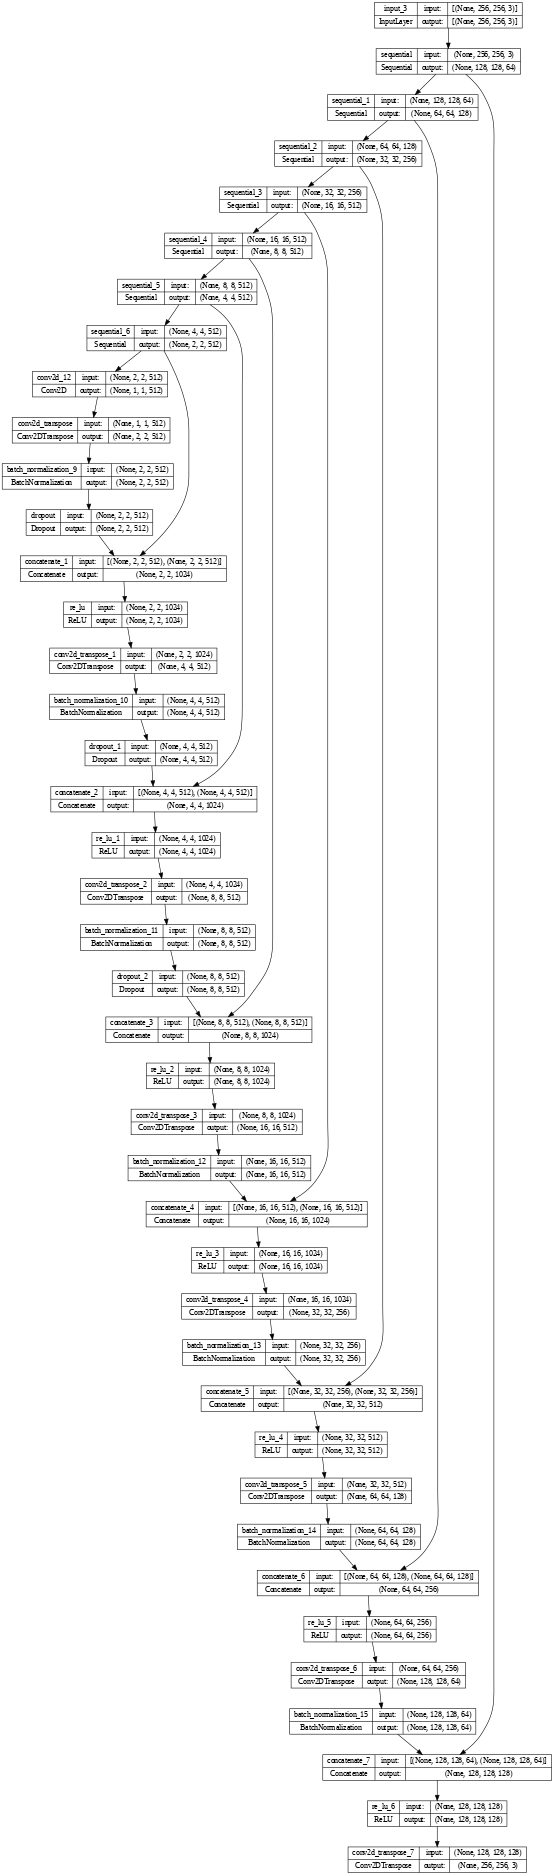

In [7]:
from keras.layers import Conv2DTranspose
from keras.models import Sequential
from keras.layers import ReLU

#downsampling the data(Encoder blocks)
def downSampling(layer_in,n_filters,batchnorm=True):
  #creating a sequential model
  model = Sequential()
  #adding a convolutional layer
  model.add(Conv2D(n_filters,(4,4),strides=(2,2),padding='same'))
  #adding batch norm
  if batchnorm:
    model.add(BatchNormalization())
  #adding Leaky ReLU with 0.2 negative slope
  model.add(LeakyReLU(alpha=0.2))
  return model(layer_in)

#upsampling the data(Decoder blocks)
def upSampling(layer_in,skip_in,n_filters,dropout=True):
  #applying convolution to layer_in
  x = Conv2DTranspose(n_filters,(4,4),strides=(2,2),padding='same')(layer_in)
  #applying batch norm
  x = BatchNormalization()(x,training = True)
  #applying dropout
  if dropout:
    x = Dropout(0.5)(x, training = True)
  #merging x with the respective skip connection
  x = Concatenate()([x,skip_in])
  #applying ReLU
  x = ReLU()(x)
  return x

#putting the encoder and encoder together in the generator
def generator_model(image_shape):
  #getting the number of channels in the image
  n_filters = image_shape[-1]
  #defining the shape of the input image
  input_img = Input(shape=image_shape)
  #encoder
  encoder1 = downSampling(input_img,64,batchnorm=False) #C64
  encoder2 = downSampling(encoder1,128) #C128
  encoder3 = downSampling(encoder2,256) #C256
  encoder4 = downSampling(encoder3,512) #C512
  encoder5 = downSampling(encoder4,512) #C512
  encoder6 = downSampling(encoder5,512) #C512
  encoder7 = downSampling(encoder6,512) #C512
  #bottleneck
  bottleneck = Conv2D(512,(4,4),strides=(2,2),padding='same',activation='relu')(encoder7)
  #decoder
  decoder1 = upSampling(bottleneck,encoder7,512) #CD512
  decoder2 = upSampling(decoder1,encoder6,512,) #CD512
  decoder3 = upSampling(decoder2,encoder5,512) #CD512
  decoder4 = upSampling(decoder3,encoder4,512,dropout=False) #C512
  decoder5 = upSampling(decoder4,encoder3,256,dropout=False) #C256
  decoder6 = upSampling(decoder5,encoder2,128,dropout=False) #C128
  decoder7 = upSampling(decoder6,encoder1,64,dropout=False) #C64
  #output
  output = Conv2DTranspose(n_filters,(4,4),strides=(2,2),padding='same',activation='tanh')(decoder7)
  model = Model(input_img,output)

  return model

generator = generator_model((256,256,3))
plot_model(generator,show_shapes=True,show_layer_names=True,dpi=40)

# Implementing the GAN

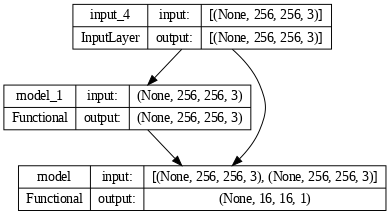

In [8]:
from keras.losses import BinaryCrossentropy
from keras.losses import MeanAbsoluteError
#tieing up the discriminator and generator to form the GAN
def gan_model(g_model,d_model,image_shape):
  #make weights in the discriminator not trainable
  for layer in d_model.layers:
    if not isinstance(layer,BatchNormalization):
      layer.trainable = False

  #define input
  input_img = Input(shape=image_shape)
  fake_img = g_model(input_img)
  d_model_out = d_model([input_img,fake_img])

  model = Model(input_img,[d_model_out,fake_img])
  opt = Adam(learning_rate=0.0002,beta_1=0.5)
  # Instantiate loss functions
  bce_loss = BinaryCrossentropy()
  mae_loss = MeanAbsoluteError()
  # Combine losses
  loss = [bce_loss, lambda y_true, y_pred: 100 * mae_loss(y_true, y_pred)]
  model.compile(loss = loss,optimizer=opt)
  return model

gan = gan_model(generator,discriminator,(256,256,3))
plot_model(gan,show_shapes=True,show_layer_names=True,dpi=70)

# Normalizing Images

In [9]:

#Normalizing images so they fall
#in the range of [-1,1]
def normalize_images(images):
  return (images - 127.5) / 127.5

src_images = normalize_images(src_images)
tar_images = normalize_images(tar_images)

# Plotting Images During Training

In [12]:
# generate samples and save as a plot and save the model
def plot_images(generator, dataset,step = None, n_samples=3,training=True):
    #extract source and target images
    src_images, tar_images = dataset
    # choose random instances
    index = np.random.randint(0, len(src_images), n_samples)
    #select random source images
    real_input = src_images[index]
    #select random target images
    real_target = tar_images[index]

    # generate a batch of fake samples
    fake_target = generator.predict(real_input)
    # scale all pixels from [-1,1] to [0,1]
    real_input = (real_input + 1) / 2.0
    real_target = (real_target + 1) / 2.0
    fake_target = (fake_target + 1) / 2.0

    # plot real source images
    for i in range(n_samples):
        plt.subplot(3, n_samples, 1 + i)
        plt.axis('off')
        plt.imshow(real_input[i])
    # plot generated target image
    for i in range(n_samples):
        plt.subplot(3, n_samples, 1 + n_samples + i)
        plt.axis('off')
        plt.imshow(fake_target[i])
    # plot real target image
    for i in range(n_samples):
        plt.subplot(3, n_samples, 1 + n_samples*2 + i)
        plt.axis('off')
        plt.imshow(real_target[i])
    # display plot
    plt.show()
    plt.close()
    if training:
      # save the generator model
      filename2 = 'model_%06d.h5' % (step+1)
      generator.save(filename2)
      print('>Saved model: %s' % (filename2))

# Training Pix2Pix GAN

1/1 [==============================] - 0s 21ms/step
>1, d1[0.325] d2[0.356] g[11.360]
1/1 [==============================] - 0s 19ms/step
>2, d1[0.138] d2[0.263] g[8.310]
1/1 [==============================] - 0s 20ms/step
>3, d1[0.033] d2[0.122] g[8.880]
1/1 [==============================] - 0s 24ms/step
>4, d1[0.164] d2[0.144] g[11.564]
1/1 [==============================] - 0s 22ms/step
>5, d1[0.027] d2[0.084] g[10.150]
1/1 [==============================] - 0s 21ms/step
>6, d1[0.007] d2[0.112] g[15.071]
1/1 [==============================] - 0s 23ms/step
>7, d1[0.003] d2[0.063] g[13.161]
1/1 [==============================] - 0s 25ms/step
>8, d1[0.603] d2[0.173] g[7.261]
1/1 [==============================] - 0s 22ms/step
>9, d1[0.009] d2[0.209] g[6.219]
1/1 [==============================] - 0s 24ms/step
>10, d1[0.002] d2[0.067] g[11.564]
1/1 [==============================] - 0s 34ms/step
>11, d1[0.254] d2[0.182] g[8.232]
1/1 [==============================] - 0s 32ms/step
>12, 

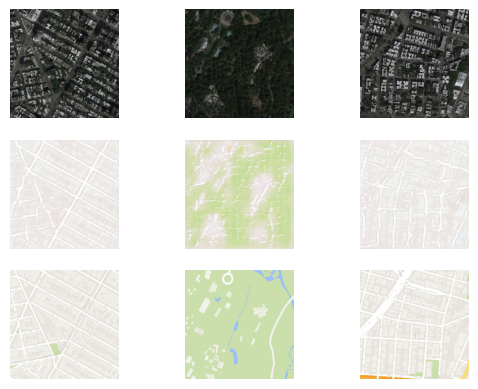

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


>Saved model: model_000001.h5
1/1 [==============================] - 0s 23ms/step
>1, d1[0.051] d2[0.130] g[13.844]
1/1 [==============================] - 0s 21ms/step
>2, d1[0.265] d2[0.374] g[7.746]
1/1 [==============================] - 0s 25ms/step
>3, d1[0.042] d2[0.214] g[8.707]
1/1 [==============================] - 0s 26ms/step
>4, d1[0.227] d2[0.122] g[9.312]
1/1 [==============================] - 0s 24ms/step
>5, d1[0.131] d2[0.085] g[10.210]
1/1 [==============================] - 0s 25ms/step
>6, d1[0.025] d2[0.279] g[15.170]
1/1 [==============================] - 0s 24ms/step
>7, d1[0.014] d2[0.098] g[13.122]
1/1 [==============================] - 0s 23ms/step
>8, d1[0.797] d2[0.088] g[7.833]
1/1 [==============================] - 0s 22ms/step
>9, d1[0.017] d2[0.091] g[6.855]
1/1 [==============================] - 0s 22ms/step
>10, d1[0.008] d2[0.449] g[11.249]
1/1 [==============================] - 0s 27ms/step
>11, d1[0.400] d2[0.075] g[9.369]
1/1 [=======================

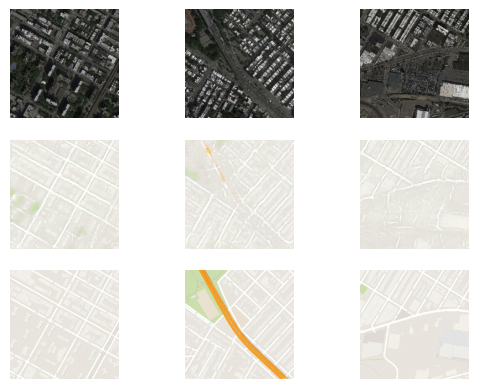

>Saved model: model_000002.h5
1/1 [==============================] - 0s 24ms/step
>1, d1[0.203] d2[0.167] g[10.578]
1/1 [==============================] - 0s 21ms/step
>2, d1[0.140] d2[0.278] g[8.314]
1/1 [==============================] - 0s 28ms/step
>3, d1[0.101] d2[0.125] g[8.192]
1/1 [==============================] - 0s 23ms/step
>4, d1[0.141] d2[0.074] g[8.350]
1/1 [==============================] - 0s 23ms/step
>5, d1[0.085] d2[0.074] g[9.626]
1/1 [==============================] - 0s 31ms/step
>6, d1[0.012] d2[0.097] g[14.199]
1/1 [==============================] - 0s 25ms/step
>7, d1[0.006] d2[0.085] g[12.691]
1/1 [==============================] - 0s 23ms/step
>8, d1[0.176] d2[0.093] g[7.785]
1/1 [==============================] - 0s 22ms/step
>9, d1[0.006] d2[0.045] g[4.970]
1/1 [==============================] - 0s 23ms/step
>10, d1[0.005] d2[1.713] g[10.290]
1/1 [==============================] - 0s 24ms/step
>11, d1[0.493] d2[0.036] g[9.709]
1/1 [========================

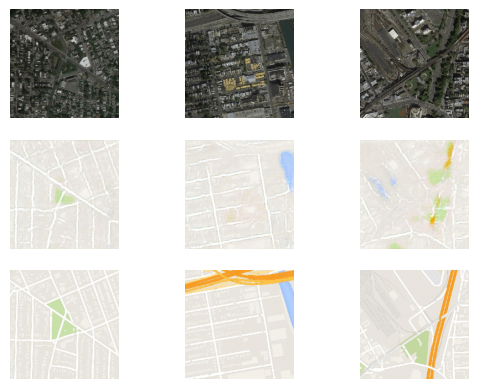

>Saved model: model_000003.h5
1/1 [==============================] - 0s 21ms/step
>1, d1[0.075] d2[0.048] g[9.795]
1/1 [==============================] - 0s 22ms/step
>2, d1[0.073] d2[0.235] g[8.004]
1/1 [==============================] - 0s 36ms/step
>3, d1[0.075] d2[0.292] g[7.967]
1/1 [==============================] - 0s 28ms/step
>4, d1[0.118] d2[0.085] g[8.934]
1/1 [==============================] - 0s 20ms/step
>5, d1[0.240] d2[0.094] g[9.744]
1/1 [==============================] - 0s 20ms/step
>6, d1[0.013] d2[0.064] g[14.314]
1/1 [==============================] - 0s 20ms/step
>7, d1[0.024] d2[0.130] g[12.281]
1/1 [==============================] - 0s 20ms/step
>8, d1[0.331] d2[0.130] g[7.930]
1/1 [==============================] - 0s 20ms/step
>9, d1[0.003] d2[0.092] g[4.805]
1/1 [==============================] - 0s 24ms/step
>10, d1[0.016] d2[0.794] g[10.113]
1/1 [==============================] - 0s 24ms/step
>11, d1[0.341] d2[0.081] g[9.583]
1/1 [=========================

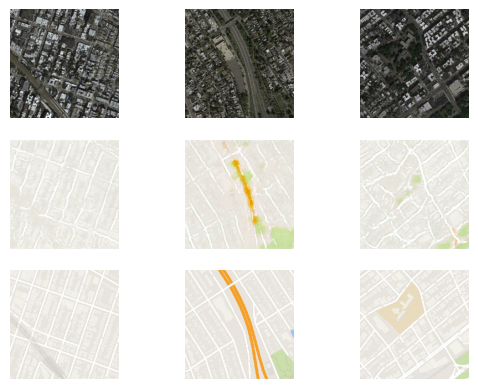

>Saved model: model_000004.h5
1/1 [==============================] - 0s 24ms/step
>1, d1[0.309] d2[0.146] g[9.116]
1/1 [==============================] - 0s 21ms/step
>2, d1[0.188] d2[0.205] g[7.617]
1/1 [==============================] - 0s 20ms/step
>3, d1[0.020] d2[0.723] g[8.446]
1/1 [==============================] - 0s 25ms/step
>4, d1[0.477] d2[0.202] g[8.714]
1/1 [==============================] - 0s 26ms/step
>5, d1[0.370] d2[0.061] g[9.871]
1/1 [==============================] - 0s 46ms/step
>6, d1[0.021] d2[0.169] g[13.349]
1/1 [==============================] - 0s 29ms/step
>7, d1[0.023] d2[0.075] g[13.050]
1/1 [==============================] - 0s 30ms/step
>8, d1[0.507] d2[0.106] g[7.090]
1/1 [==============================] - 0s 39ms/step
>9, d1[0.018] d2[0.058] g[3.718]
1/1 [==============================] - 0s 46ms/step
>10, d1[0.005] d2[1.045] g[9.862]
1/1 [==============================] - 0s 34ms/step
>11, d1[0.276] d2[0.030] g[9.137]
1/1 [==========================

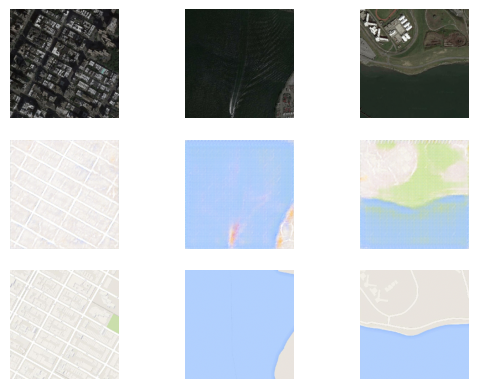

>Saved model: model_000005.h5
1/1 [==============================] - 0s 24ms/step
>1, d1[0.229] d2[0.053] g[8.679]
1/1 [==============================] - 0s 24ms/step
>2, d1[0.110] d2[0.264] g[7.496]
1/1 [==============================] - 0s 36ms/step
>3, d1[0.044] d2[0.363] g[7.714]
1/1 [==============================] - 0s 32ms/step
>4, d1[0.042] d2[0.219] g[8.620]
1/1 [==============================] - 0s 34ms/step
>5, d1[0.313] d2[0.028] g[10.390]
1/1 [==============================] - 0s 54ms/step
>6, d1[0.030] d2[0.150] g[13.527]
1/1 [==============================] - 0s 37ms/step
>7, d1[0.018] d2[0.099] g[12.808]
1/1 [==============================] - 0s 44ms/step
>8, d1[0.317] d2[0.128] g[7.193]
1/1 [==============================] - 0s 35ms/step
>9, d1[0.005] d2[0.038] g[3.124]
1/1 [==============================] - 0s 27ms/step
>10, d1[0.008] d2[0.867] g[10.203]
1/1 [==============================] - 0s 27ms/step
>11, d1[0.365] d2[0.051] g[9.766]
1/1 [========================

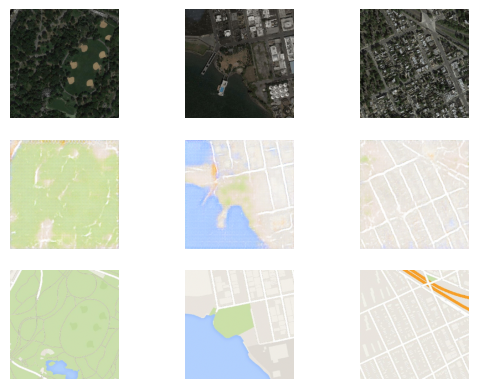

>Saved model: model_000006.h5
1/1 [==============================] - 0s 38ms/step
>1, d1[0.103] d2[0.042] g[8.165]
1/1 [==============================] - 0s 34ms/step
>2, d1[0.137] d2[0.235] g[7.832]
1/1 [==============================] - 0s 38ms/step
>3, d1[0.095] d2[0.193] g[7.573]
1/1 [==============================] - 0s 21ms/step
>4, d1[0.251] d2[0.126] g[10.021]
1/1 [==============================] - 0s 32ms/step
>5, d1[0.087] d2[0.113] g[10.063]
1/1 [==============================] - 0s 22ms/step
>6, d1[0.015] d2[0.164] g[13.933]
1/1 [==============================] - 0s 27ms/step
>7, d1[0.026] d2[0.057] g[12.653]
1/1 [==============================] - 0s 26ms/step
>8, d1[0.370] d2[0.132] g[6.935]
1/1 [==============================] - 0s 25ms/step
>9, d1[0.014] d2[0.022] g[3.405]
1/1 [==============================] - 0s 30ms/step
>10, d1[0.012] d2[0.836] g[10.040]
1/1 [==============================] - 0s 34ms/step
>11, d1[0.401] d2[0.074] g[8.414]
1/1 [=======================

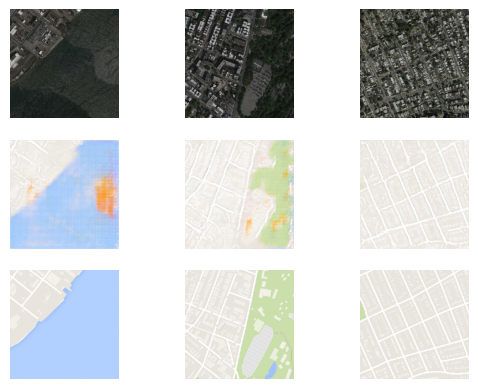

>Saved model: model_000007.h5
1/1 [==============================] - 0s 25ms/step
>1, d1[0.035] d2[0.084] g[9.112]
1/1 [==============================] - 0s 20ms/step
>2, d1[0.055] d2[0.204] g[7.057]
1/1 [==============================] - 0s 28ms/step
>3, d1[0.073] d2[0.209] g[7.189]
1/1 [==============================] - 0s 25ms/step
>4, d1[0.031] d2[0.016] g[9.982]
1/1 [==============================] - 0s 27ms/step
>5, d1[0.104] d2[0.062] g[9.376]
1/1 [==============================] - 0s 33ms/step
>6, d1[0.020] d2[0.134] g[13.267]
1/1 [==============================] - 0s 31ms/step
>7, d1[0.022] d2[0.092] g[11.436]
1/1 [==============================] - 0s 25ms/step
>8, d1[0.307] d2[0.309] g[7.495]
1/1 [==============================] - 0s 25ms/step
>9, d1[0.006] d2[0.033] g[2.894]
1/1 [==============================] - 0s 31ms/step
>10, d1[0.042] d2[0.321] g[9.271]
1/1 [==============================] - 0s 28ms/step
>11, d1[0.553] d2[0.225] g[9.853]
1/1 [==========================

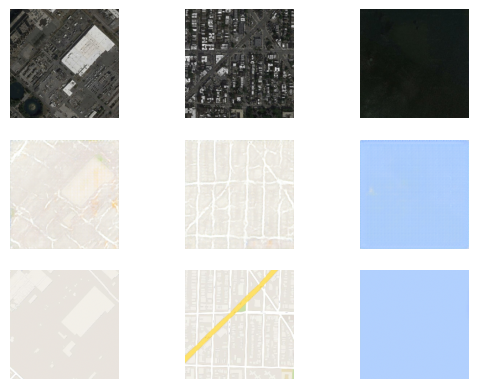

>Saved model: model_000008.h5
1/1 [==============================] - 0s 21ms/step
>1, d1[0.095] d2[0.062] g[7.675]
1/1 [==============================] - 0s 29ms/step
>2, d1[0.453] d2[0.409] g[7.783]
1/1 [==============================] - 0s 38ms/step
>3, d1[0.304] d2[0.367] g[7.375]
1/1 [==============================] - 0s 31ms/step
>4, d1[0.100] d2[0.115] g[7.873]
1/1 [==============================] - 0s 29ms/step
>5, d1[0.188] d2[0.170] g[9.485]
1/1 [==============================] - 0s 50ms/step
>6, d1[0.027] d2[0.209] g[13.082]
1/1 [==============================] - 0s 38ms/step
>7, d1[0.032] d2[0.124] g[12.223]
1/1 [==============================] - 0s 34ms/step
>8, d1[0.388] d2[0.132] g[6.621]
1/1 [==============================] - 0s 61ms/step
>9, d1[0.014] d2[0.054] g[2.852]
1/1 [==============================] - 0s 25ms/step
>10, d1[0.022] d2[1.143] g[9.281]
1/1 [==============================] - 0s 31ms/step
>11, d1[0.396] d2[0.165] g[8.075]
1/1 [==========================

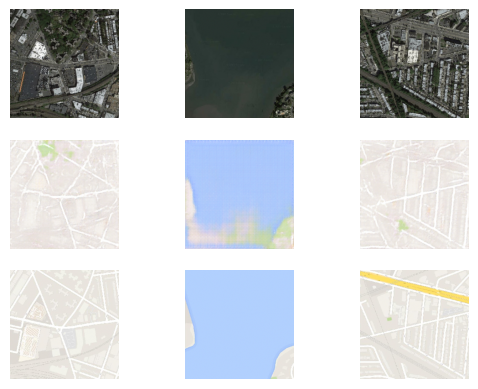

>Saved model: model_000009.h5
1/1 [==============================] - 0s 27ms/step
>1, d1[0.232] d2[0.093] g[7.976]
1/1 [==============================] - 0s 25ms/step
>2, d1[0.071] d2[0.326] g[7.041]
1/1 [==============================] - 0s 33ms/step
>3, d1[0.118] d2[0.309] g[7.592]
1/1 [==============================] - 0s 40ms/step
>4, d1[0.397] d2[0.256] g[7.935]
1/1 [==============================] - 0s 34ms/step
>5, d1[0.217] d2[0.168] g[9.613]
1/1 [==============================] - 0s 35ms/step
>6, d1[0.100] d2[0.141] g[13.592]
1/1 [==============================] - 0s 34ms/step
>7, d1[0.043] d2[0.154] g[11.426]
1/1 [==============================] - 0s 41ms/step
>8, d1[0.274] d2[0.116] g[6.525]
1/1 [==============================] - 0s 42ms/step
>9, d1[0.046] d2[0.056] g[3.052]
1/1 [==============================] - 0s 49ms/step
>10, d1[0.026] d2[1.265] g[9.082]
1/1 [==============================] - 0s 43ms/step
>11, d1[0.408] d2[0.127] g[8.144]
1/1 [==========================

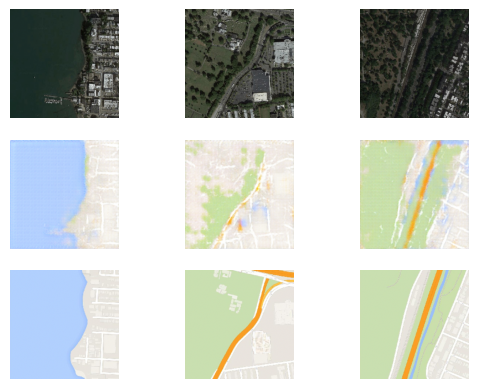

>Saved model: model_000010.h5


In [13]:
def train_discriminator(discriminator, src_batch, tar_batch, fake_batch, y_real, y_fake):
    d_loss_real = discriminator.train_on_batch([src_batch, tar_batch], y_real)
    d_loss_fake = discriminator.train_on_batch([src_batch, fake_batch], y_fake)
    return d_loss_real, d_loss_fake

def train_generator(gan, src_batch, y_real, tar_batch):
    gan_loss,_ ,_= gan.train_on_batch(src_batch, [y_real, tar_batch])
    return gan_loss

def train_gan(gan,generator,discriminator,dataset,n_epochs=10,n_batch=1):
  n_patch = discriminator.output_shape[1]
  src_img,tar_img = dataset
  for epoch in range(n_epochs):
    for i in range(len(src_img/n_batch)):
      #getting batch for src and tar images and labels
      src_batch = src_img[i*n_batch:(i+1)*n_batch]
      tar_batch = tar_img[i*n_batch:(i+1)*n_batch]
      y_real = np.ones((src_batch.shape[0],n_patch,n_patch,1))
      #generating fake images and labels via generator
      fake_batch = generator.predict(src_batch)
      y_fake = np.zeros((src_batch.shape[0],n_patch,n_patch,1))
      #training discriminator
      discriminator_loss_real,discriminator_loss_fake = train_discriminator(discriminator,src_batch,tar_batch,fake_batch,y_real,y_fake)


      #training generator
      gan_loss = train_generator(gan,src_batch,y_real,tar_batch)


      #show metrics
      print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, discriminator_loss_real, discriminator_loss_fake, gan_loss))
    #print generated images
    plot_images(generator,dataset,epoch)


dataset = [src_images,tar_images]
train_gan(gan,generator,discriminator,dataset)

# Results

1/1 [==============================] - 0s 26ms/step


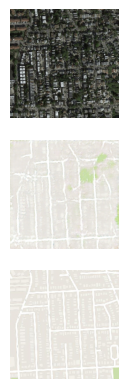

In [16]:
#Run this cell as much as you want to check the results
plot_images(generator,dataset,training=False,n_samples=1)